In [1]:
## Import stuff and define some helper functions
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (9., 6.)
plt.rcParams['figure.dpi'] = 200


# We use monthly data throughout so annualize by multiplying by sqrt(12)
def sharpe(x):
    return x.mean() / x.std() * np.sqrt(12)

In [2]:
## Load data
# SP500 index/dividend and inflation data originally from Robert Shiller: http://www.econ.yale.edu/~shiller/data/ie_data.xls
# Methodology available at http://www.econ.yale.edu/~shiller/data.htm
# I re-saved the Data sheet with LibreOffice so that I don't need to pull in Excel parsers...
# Months are a bit screwed (e.g. 1870.1 instead of 1870.10) and column headings are across several cells
# so I manually extract things that we need here

initial_df = pd.read_csv('ie_data.csv')
date_range = pd.date_range(start=dt(1871, 2, 1), end=dt(2018, 4, 1), freq='M')

# Unadjusted for inflation. The sheet also has data in March 2018 dollars but it's easier to do it ourselves
sp500 = pd.DataFrame(index=date_range, data={'SP500': initial_df.iloc[8:-1, 1].astype(float).tolist()})
dividends = pd.DataFrame(index=date_range, data={'Dividends': initial_df.iloc[8:-1, 2].astype(float).tolist()})

cpi = pd.DataFrame(index=date_range, data={'CPI': initial_df.iloc[8:-1, 4].astype(float).tolist()})

# SP500 total return index (price return + dividends) from Yahoo! Finance to see whether our index is correct
tri_yfin = pd.read_csv("^SP500TR.csv", parse_dates=True, index_col=0)[['Adj Close']]

In [3]:
# Construct indices
# Dividends are paid quarterly but interpolated in Shiller's data to monthly + they are annualized,
# so they are divided by 12 to pretend we're receiving (and reinvesting them) monthly. Shouldn't affect compounding too much.

tr_noinfl_nodiv = sp500.pct_change()['SP500']
tr_noinfl = tr_noinfl_nodiv + (dividends['Dividends'].shift(1) / 12. / sp500['SP500'])

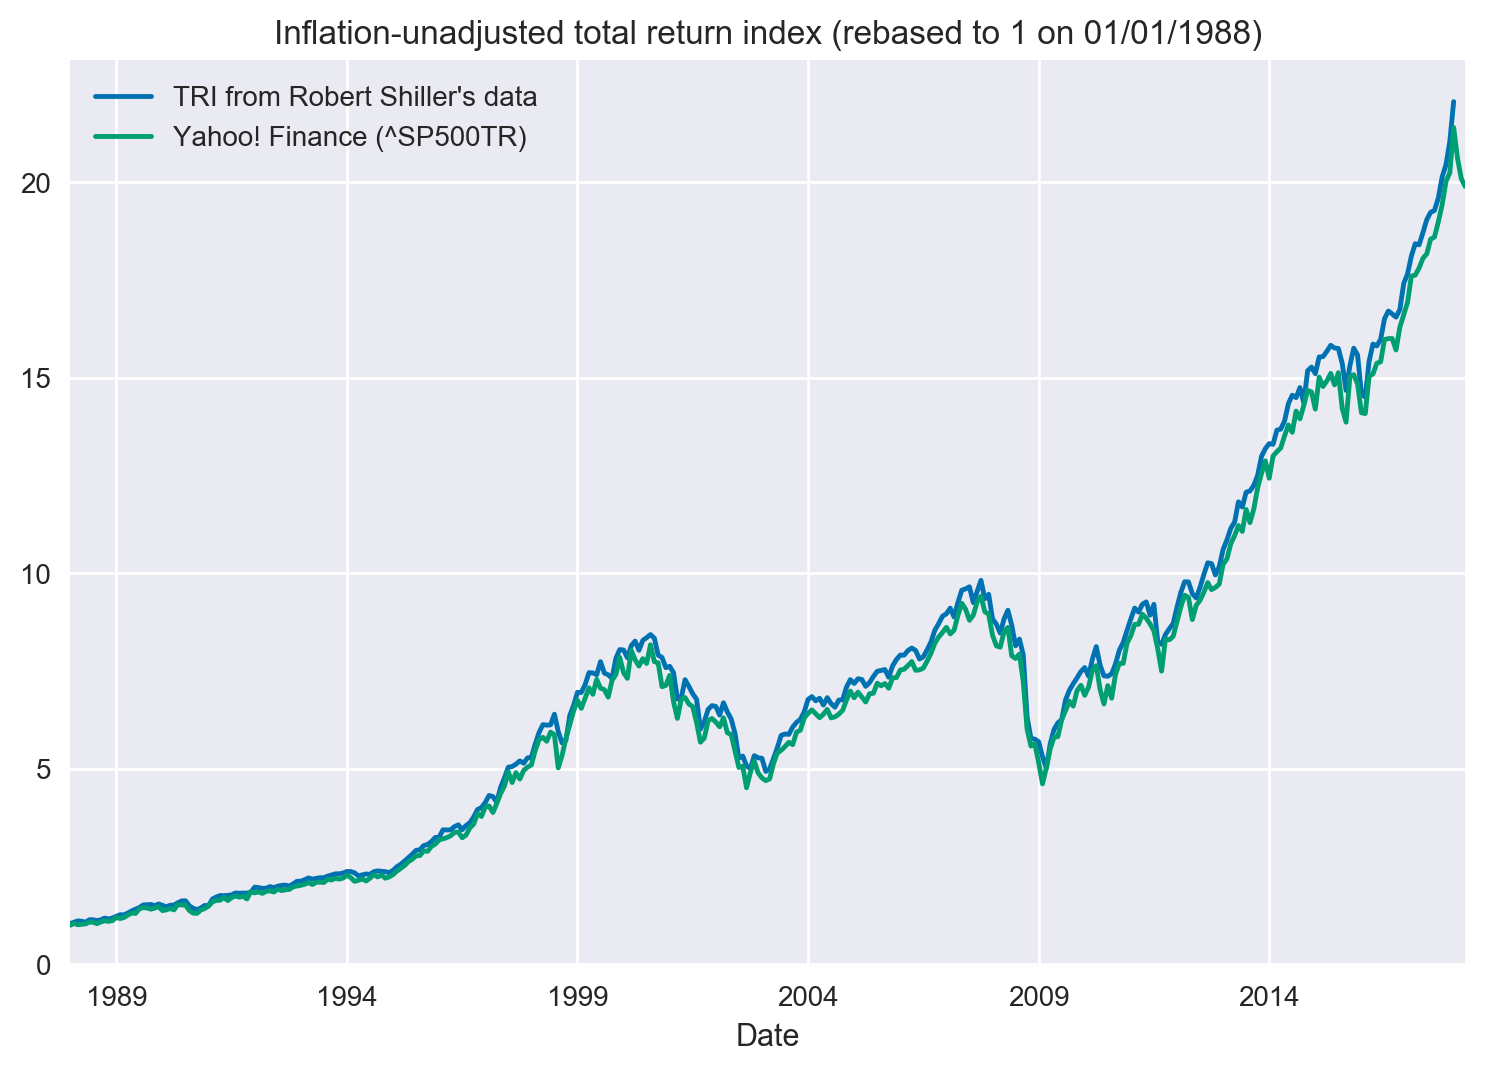

In [4]:
# Compare with the reference total return index from Yahoo!
# Rebase to start in the same month

tri_noinfl_rebase = (1 + tr_noinfl[tri_yfin.index[0]:]).cumprod()
tri_yfin_rebase = tri_yfin / tri_yfin.iloc[0]

ax = tri_noinfl_rebase.plot()
tri_yfin_rebase.plot(ax=ax)
plt.legend(['TRI from Robert Shiller\'s data', 'Yahoo! Finance (^SP500TR)'])
plt.title('Inflation-unadjusted total return index (rebased to 1 on 01/01/1988)')
plt.savefig("rshiller_yfin_comparison.png")

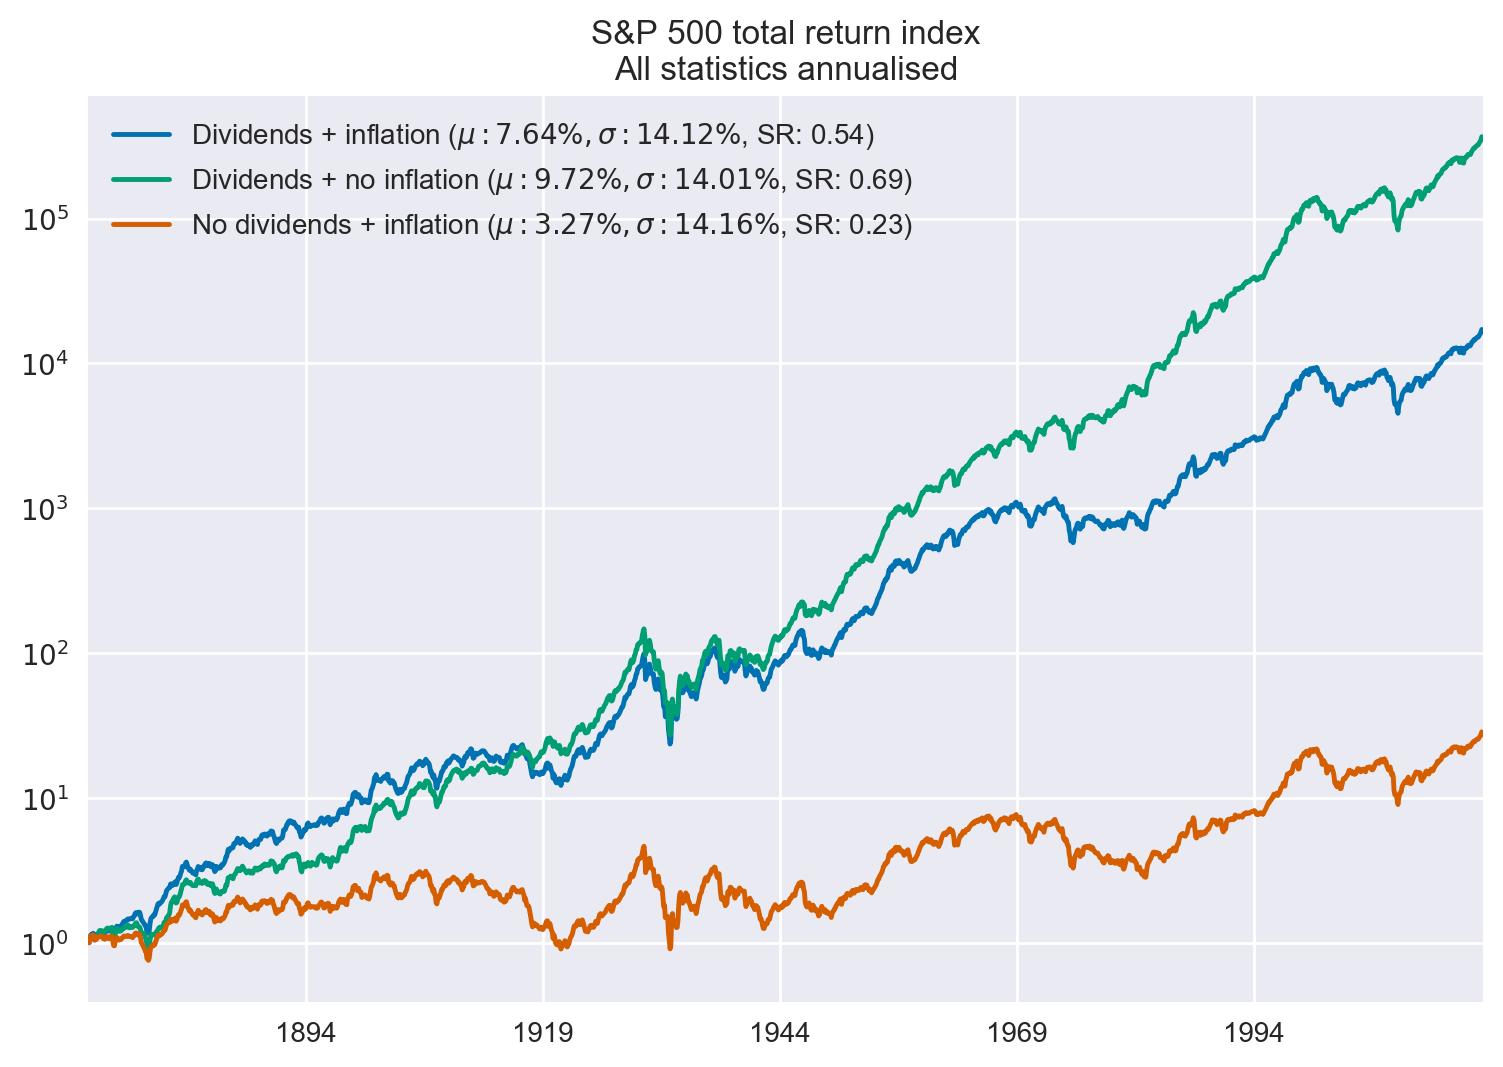

In [5]:
# Doesn't seem to diverge too much, let's keep going
# Adjust for inflation (subtract monthly CPI change from the total return)
tr_infl = pd.DataFrame(data={'Total return': tr_noinfl - cpi.pct_change()['CPI']}).dropna()
tr_infl_nodiv = pd.DataFrame(data={'Total return': tr_noinfl_nodiv - cpi.pct_change()['CPI']}).dropna()


ax = (1+tr_infl).cumprod().plot()
(1+tr_noinfl).cumprod().plot(ax=ax)
(1+tr_infl_nodiv).cumprod().plot(ax=ax)
ax.set_yscale('log')
plt.legend(['%s ($\mu: %.2f\%%, \sigma: %.2f\%%$, SR: %.2f)' 
            % (l, np.mean(d) * 12 * 100, np.std(d) * np.sqrt(12) * 100, sharpe(d))
            for l, d in zip(['Dividends + inflation',
                             'Dividends + no inflation',
                             'No dividends + inflation'], [tr_infl, tr_noinfl, tr_infl_nodiv])])
plt.title('S&P 500 total return index\nAll statistics annualised')
plt.savefig("tri_div_infl_comparison.png")

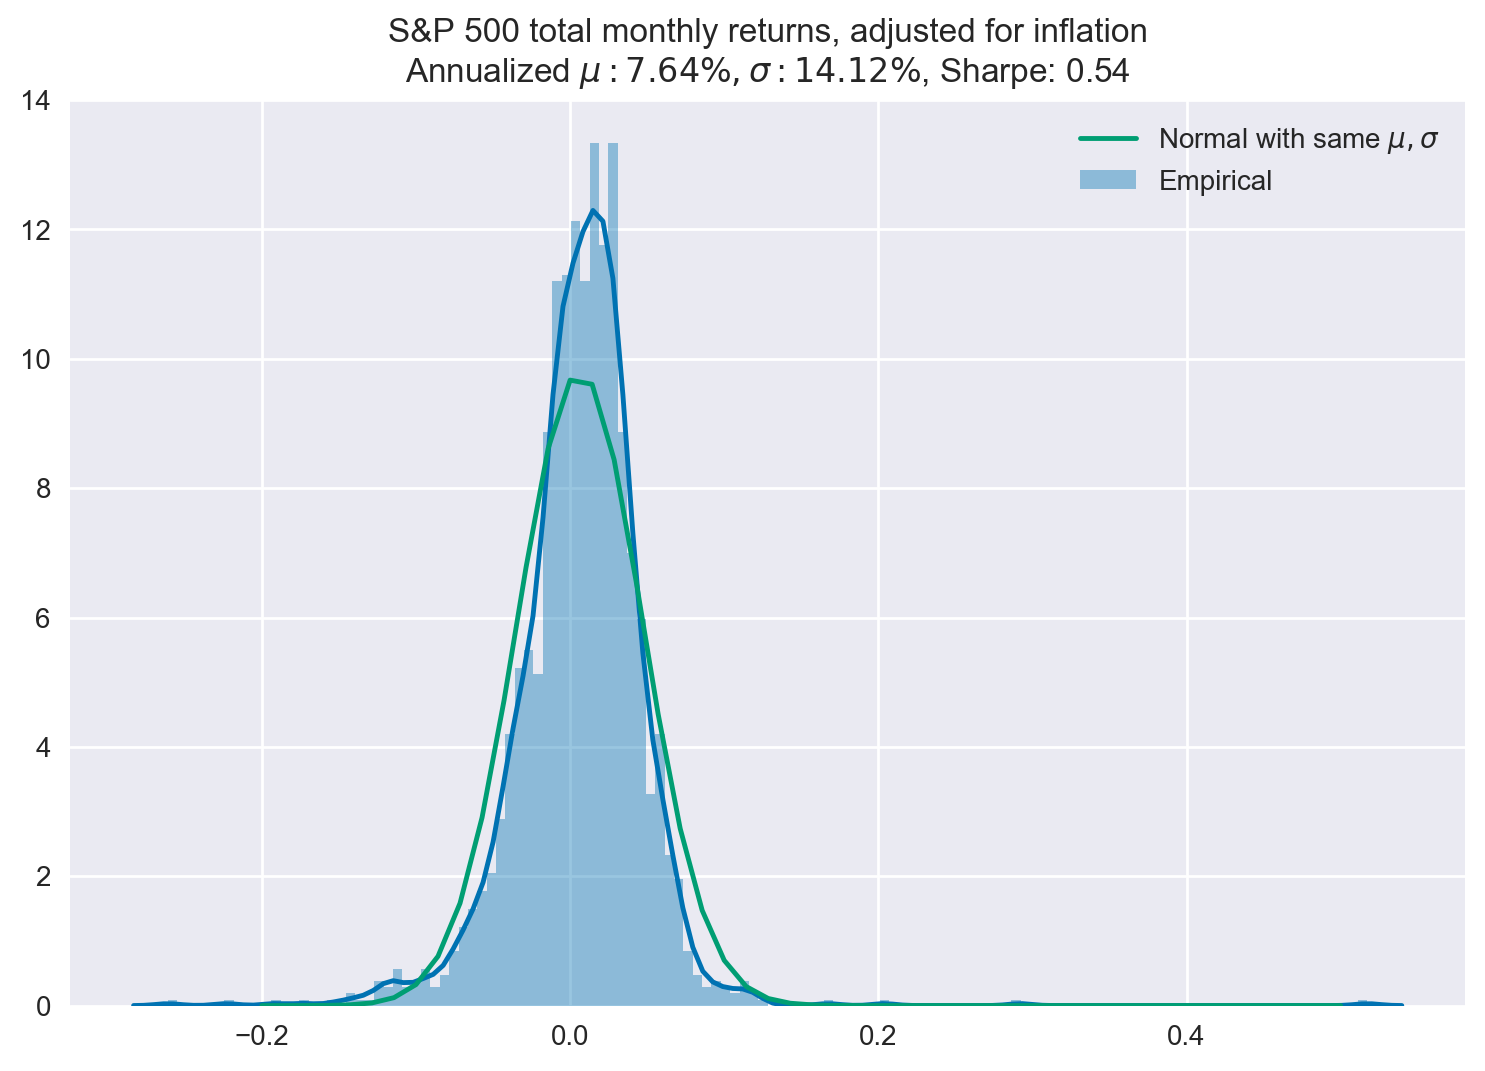

In [6]:
sns.distplot(tr_infl, bins=128)
plt.title('S&P 500 total monthly returns, adjusted for inflation\nAnnualized $\mu: %.2f\%%, \sigma: %.2f\%%$, Sharpe: %.2f'
          % (np.mean(tr_infl) * 12 * 100, np.std(tr_infl) * np.sqrt(12) * 100, sharpe(tr_infl)))
# Plot a normal distribution on top
X = np.linspace(-0.2, 0.5)
Y = ss.norm.pdf(X, loc=np.mean(tr_infl), scale=np.std(tr_infl))
plt.plot(X, Y)
plt.legend(['Normal with same $\mu, \sigma$', 'Empirical'])
plt.savefig("tri_vs_normal.png")

In [7]:
# Test for normality too for good measure
ss.normaltest(tr_infl)

NormaltestResult(statistic=array([ 522.19501515]), pvalue=array([  4.04383308e-114]))

C:\Users\mildbyte\Anaconda2\lib\site-packages\matplotlib\transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


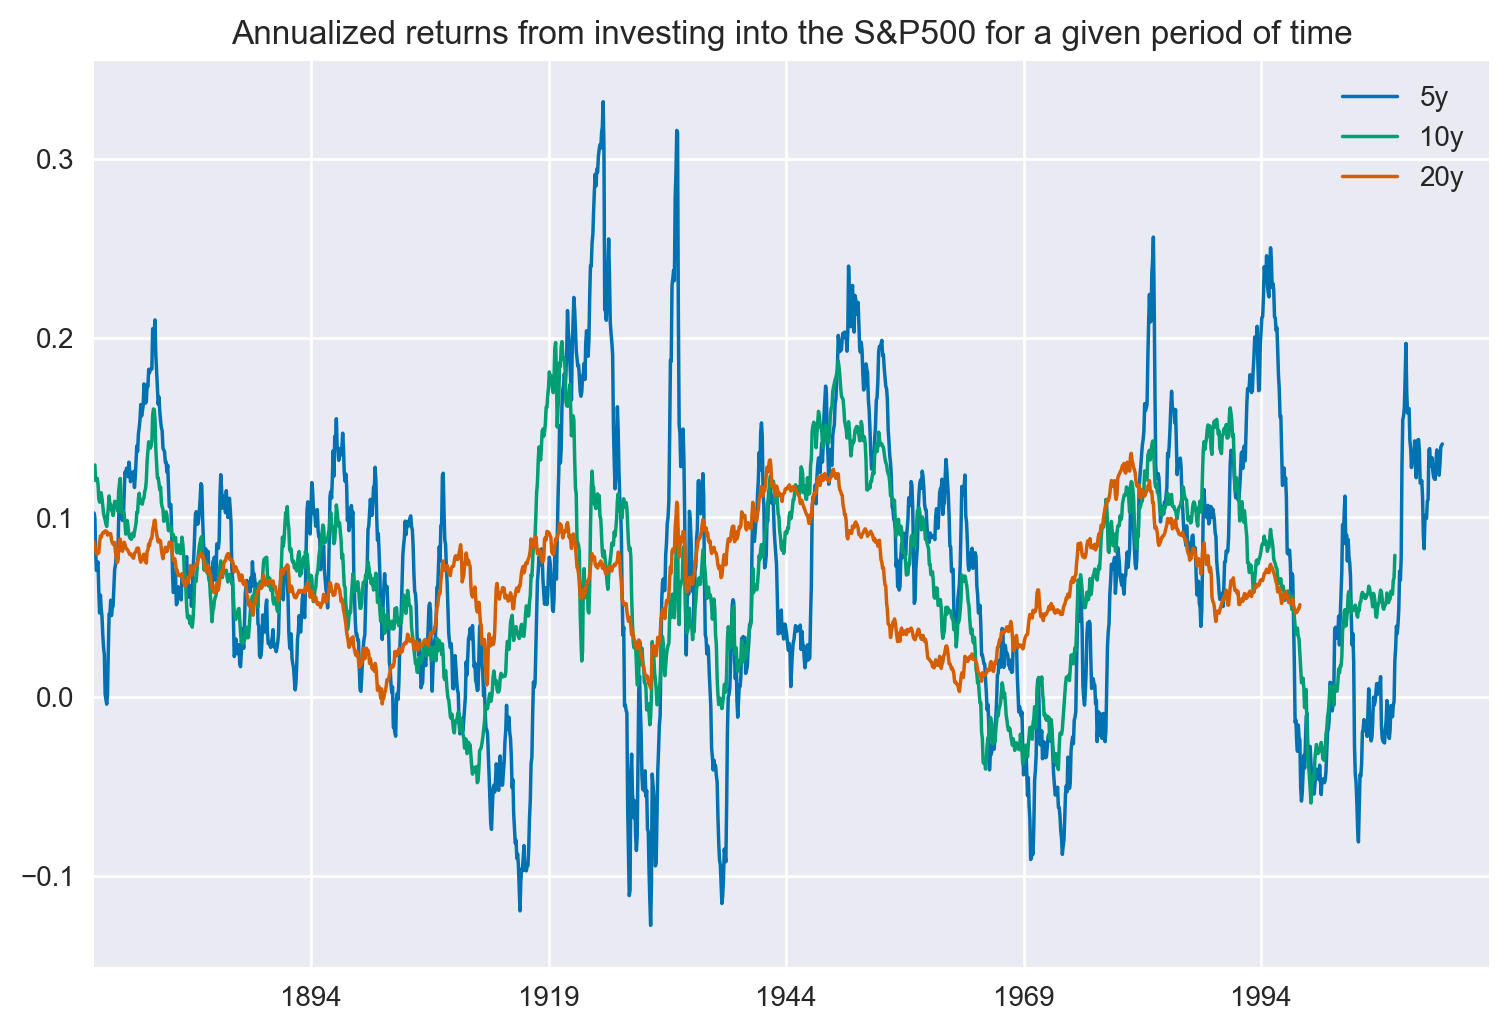

In [8]:
# p extremely small, reject the null hypothesis that tr_infl comes from a normal distribution.
# Testing lump sum / buy-and-hold
# Let's do some estimates of annualised returns based on when we invested
horizons = [5, 10, 20]
plt.figure()
ax = plt.gca()

for h in horizons:
    # Shift by -12*horizon so that the rolling window is looking forward, not back (e.g. the point in 2008 shows what
    # would happen if we invested in 2008, not withdrew in 2008)
    tr_infl.rolling(12*h).apply(lambda x: np.prod(1+x) ** (1./h) - 1).shift(-12*h+1).plot(ax=ax, linewidth=1.25)
plt.legend(['%dy' % h for h in horizons])
plt.title('Annualized returns from investing into the S&P500 for a given period of time')
plt.savefig("sp500_bah.png")

In [9]:
# Simulate one portfolio by drawing multiple returns from the empirical distribution
def sample_total_return(years=20):
    return np.prod(1 + np.random.choice(tr_infl.as_matrix().T[0], 12 * years)) - 1

# As well as simulate us holding cash for a given amount of years (gets eaten by inflation)
cpi_change = cpi.pct_change().dropna()
def sample_inflation_return(years=20):
    return np.prod(1 - np.random.choice(cpi_change.as_matrix().T[0], 12 * years)) - 1

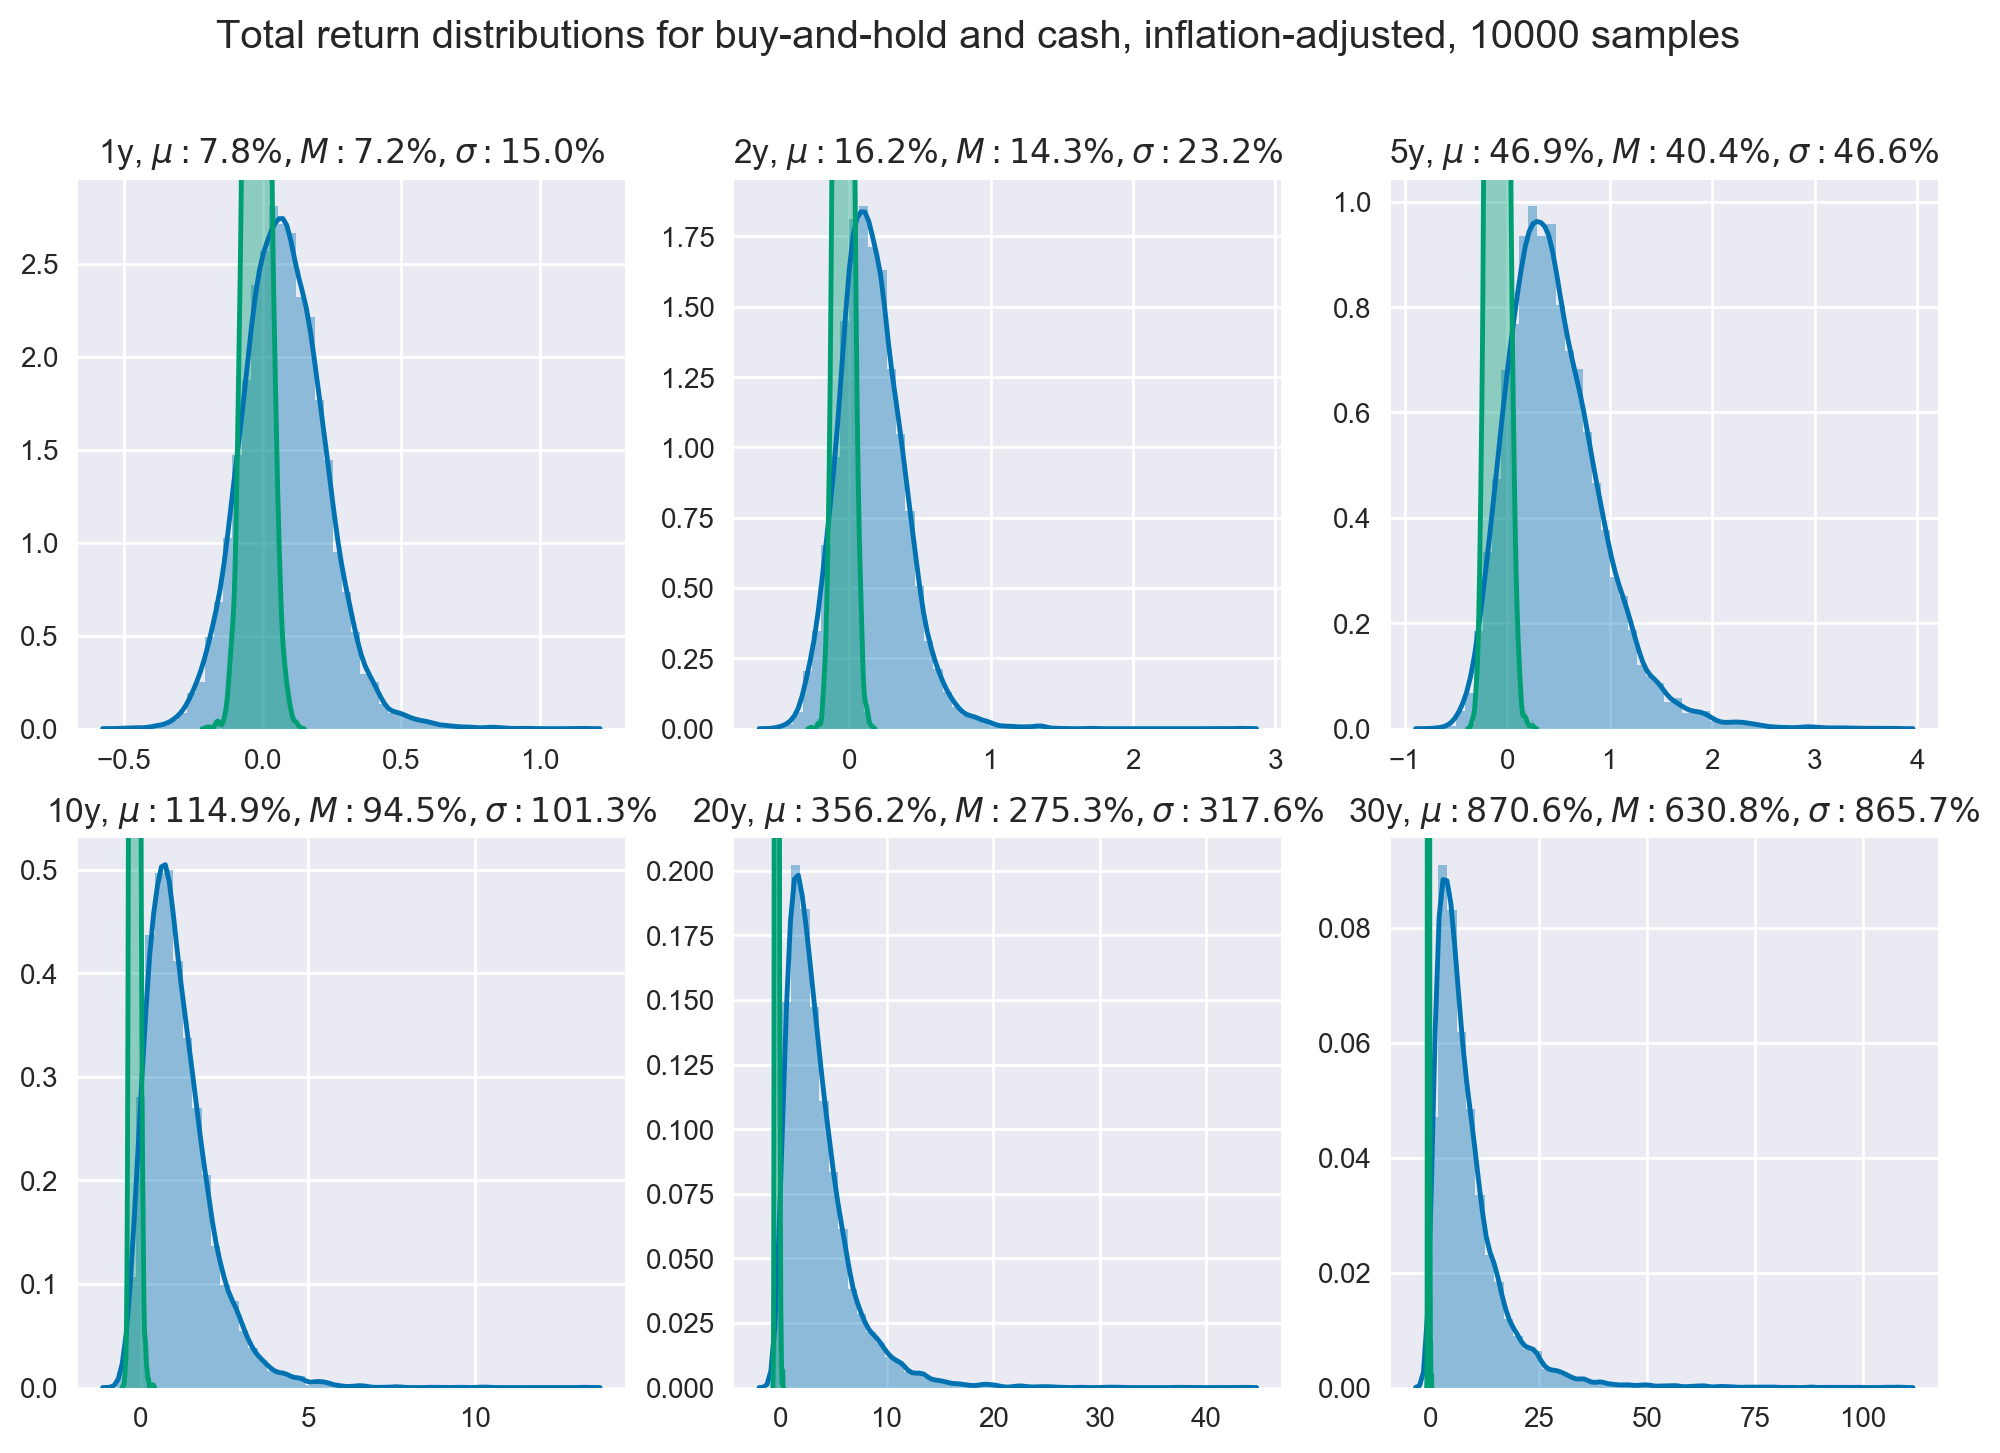

In [10]:
# Plot some return distributions for different investment horizons
N = 10000
horizons = [[1, 2, 5],
            [10, 20, 30]]
plt.figure(figsize=(12, 8))
for i in xrange(2):
    for j in xrange(3):
        y = horizons[i][j]
        samples = [sample_total_return(y) for _ in xrange(N)]
        infl = [sample_inflation_return(y) for _ in xrange(N)]
        plt.subplot(2, 3, i*3+j+1)
        
        # Maintain the ylim of the total return so that there's sensible scaling
        ax = sns.distplot(samples)
        ylim = ax.get_ylim()
        sns.distplot(infl)
        ax.set_ylim(ylim)
        plt.title('%dy, $\mu: %.1f\%%, M: %.1f\%%, \sigma: %.1f\%%$' %
                  (y, np.mean(samples) * 100, np.median(samples) * 100, np.std(samples) * 100))
plt.suptitle("Total return distributions for buy-and-hold and cash, inflation-adjusted, %d samples" % N)
plt.savefig("sp500_bah_dists.png")

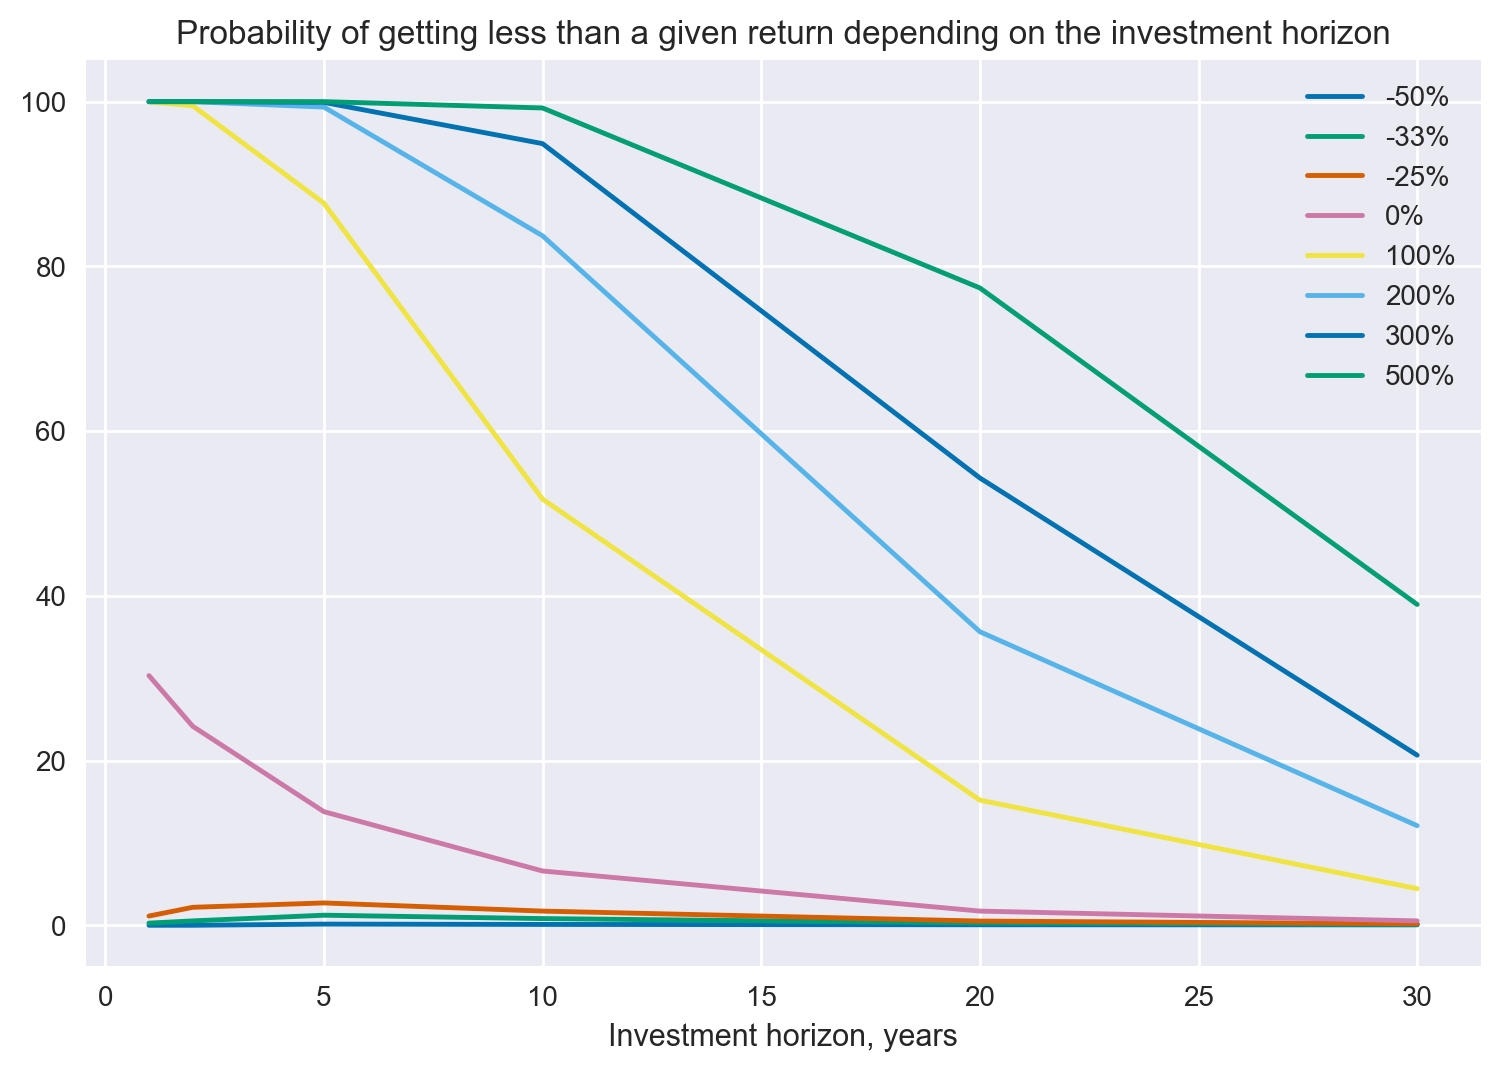

In [11]:
# Instead of looking at distributions, plot the probabilities of us getting less than the given return
horizons = [1, 2, 5, 10, 20, 30]
scores = [-0.5, -0.33, -0.25, 0, 1., 2., 3., 5.]

def get_percentiles(y, scores):
    samples = np.array([sample_total_return(years=y) for _ in xrange(N)])
    return [ss.percentileofscore(samples, s) for s in scores]

percs = [get_percentiles(h, scores) for h in horizons]
plt.plot(horizons, percs)
plt.legend(["%d%%" % (s * 100) for s in scores])
plt.xlabel("Investment horizon, years")
plt.title("Probability of getting less than a given return depending on the investment horizon")
plt.savefig("sp500_bah_hazard.png")

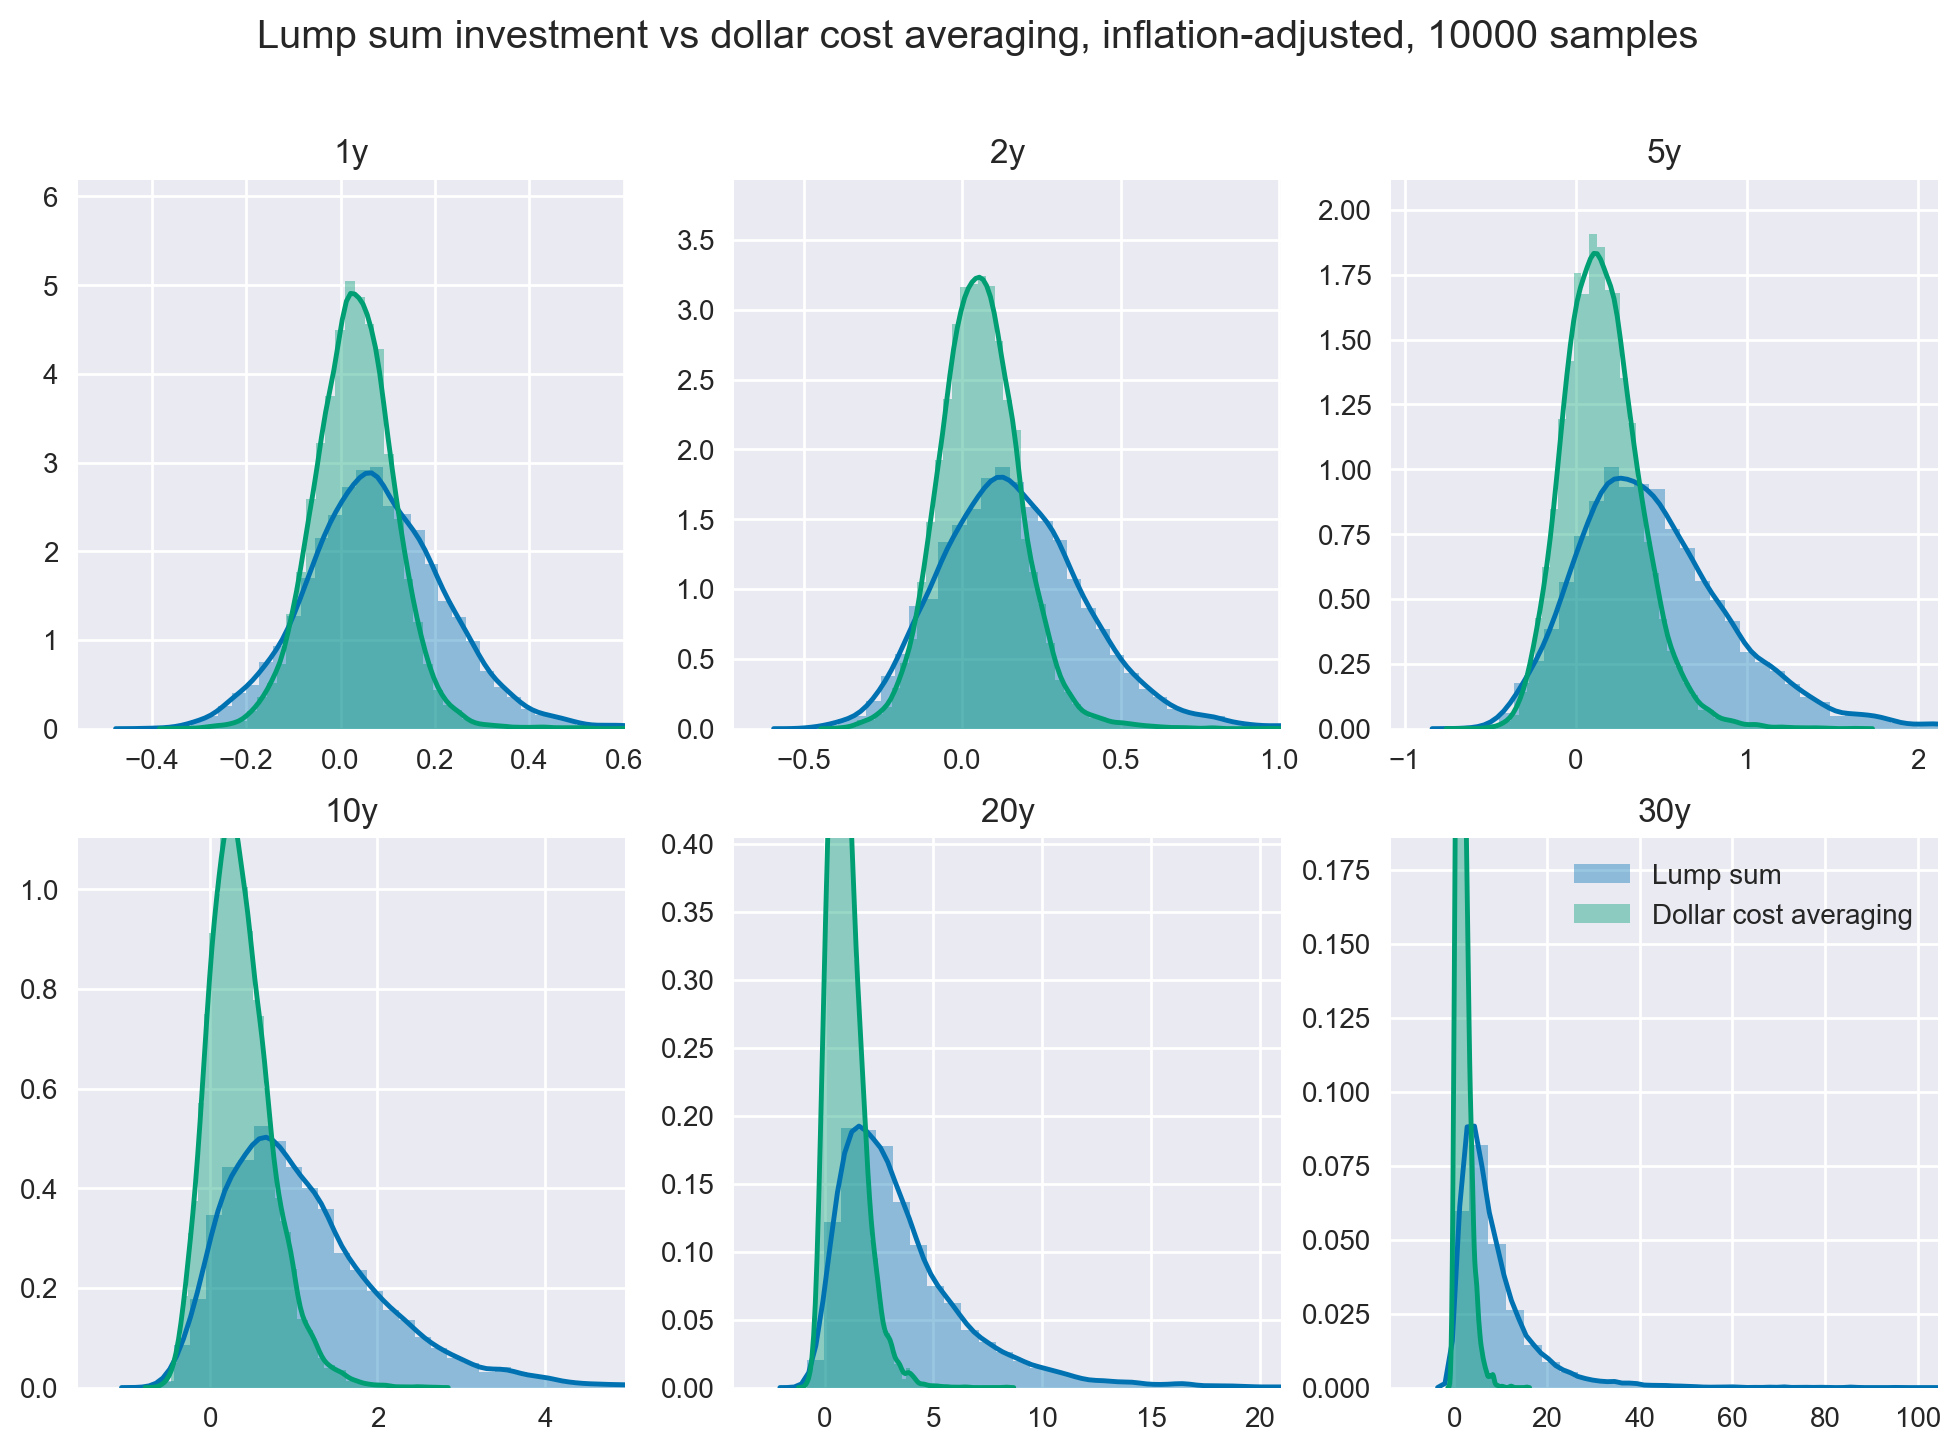

In [12]:
# Simulate dollar cost averaging
def sample_dca_return(years):
    # Pretend an increasing fraction of our portfolio is getting invested every month over the horizon
    # Strictly speaking, we are investing the same amount, inflation adjusted, every month (which
    # kind of presumes that we know what the inflation will be in the future?)
    invested_fraction = np.linspace(0, 1, years * 12)
    
    # Sample some SP500 monthly returns
    # Then, 1 month's return is earned by all of the money, 1 month's return is earned by (N-1)/N of the invested money etc.
    sp_return = np.prod(1 + invested_fraction * np.random.choice(tr_infl.as_matrix().T[0], 12 * years)) - 1
    
    # In the meantime, the uninvested part loses value with inflation
    cash_return = np.prod(1 - invested_fraction * np.random.choice(cpi_change.as_matrix().T[0], 12 * years)) - 1
    return sp_return + cash_return

# Plot some comparisons
horizons = [[1, 2, 5],
            [10, 20, 30]]
plt.figure(figsize=(12, 8))
for i in xrange(2):
    for j in xrange(3):
        y = horizons[i][j]
        lump = [sample_total_return(y) for _ in xrange(N)]
        dca = [sample_dca_return(y) for _ in xrange(N)]
        plt.subplot(2, 3, i*3+j+1)
        ylim = sns.distplot(lump).get_ylim()
        # Stretch the plots since seaborn's default xlims are way too wide and scale so lump sum takes 1/2 vertically
        xlim = sns.distplot(dca).get_xlim()
        plt.gca().set_xlim((xlim[0], xlim[1] * 0.5))
        plt.gca().set_ylim((ylim[0], ylim[1] * 2.))
        plt.title('%dy' % y)
plt.suptitle("Lump sum investment vs dollar cost averaging, inflation-adjusted, %d samples" % N)
plt.legend(['Lump sum', 'Dollar cost averaging'])
plt.savefig("sp500_lump_vs_dca.png")

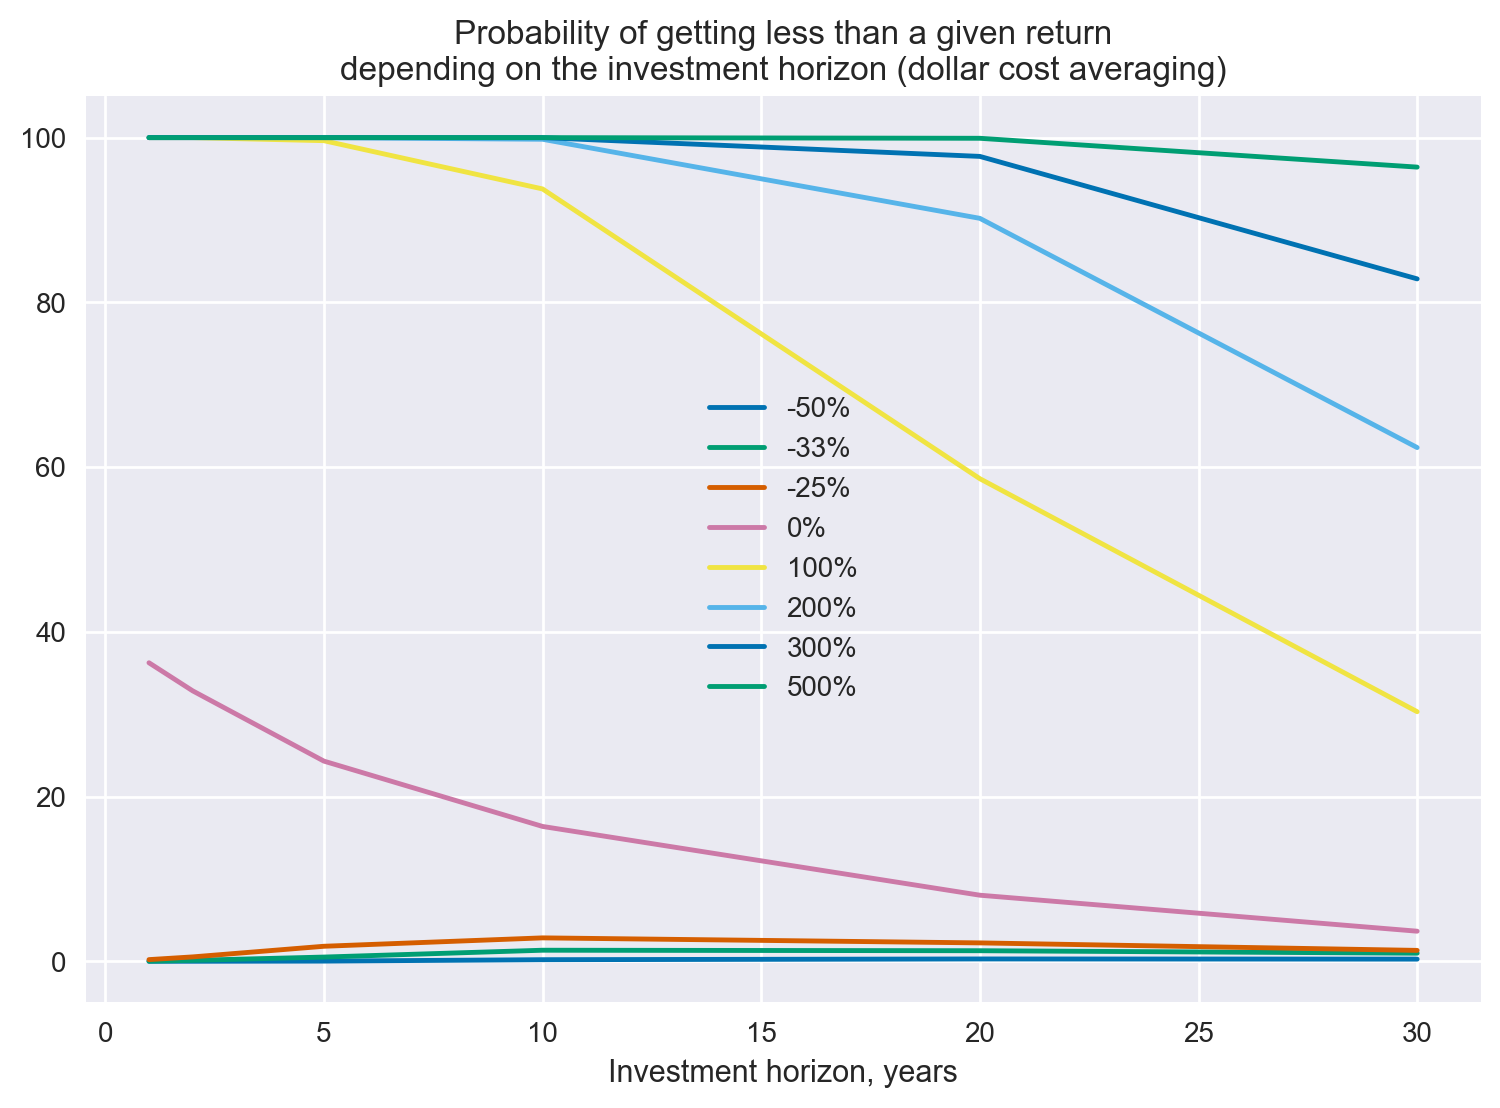

In [13]:
# And plot the same hazard curves for DCA
horizons = [1, 2, 5, 10, 20, 30]
scores = [-0.5, -0.33, -0.25, 0, 1., 2., 3., 5.]

def get_percentiles(y, scores):
    samples = np.array([sample_dca_return(years=y) for _ in xrange(N)])
    return [ss.percentileofscore(samples, s) for s in scores]

percs = [get_percentiles(h, scores) for h in horizons]
plt.plot(horizons, percs)
plt.legend(["%d%%" % (s * 100) for s in scores])
plt.xlabel("Investment horizon, years")
plt.title("Probability of getting less than a given return\ndepending on the investment horizon (dollar cost averaging)")
plt.savefig("sp500_dca_hazard.png")